In [1]:
import model_based_mvpa as mbmvpa
from model_based_mvpa.preprocessing.bids import *
from model_based_mvpa.preprocessing.events import *
from model_based_mvpa.data.loader import *
from model_based_mvpa.models.model import *

In [2]:
root = Path('/data2/project_model_based_fmri/ds001882/')

In [3]:
layout = BIDSLayout(root, derivatives=True)

## PREPROCESS FMRI IMAGE

In [ ]:
X, voxel_mask, layout = bids_preprocess(layout=layout, smoothing_fwhm=None, zoom=(2, 2, 2), ncore=2, nthread=3)

In [ ]:
#todo: maskdata visualization

## PREPRROCESS EVENT DATA

In [4]:
def example_piva_adjust_columns(row):
    ## rename data in a row to the name which can match hbayesdm.dd_hyperbolic requirements ##
    if row["delay_left"] >= row["delay_right"]:
        row["delay_later"] = row["delay_left"]
        row["delay_sooner"] = row["delay_right"]
        row["amount_later"] = row["money_left"]
        row["amount_sooner"] = row["money_right"]
        row["choice"] = 1 if row["choice"] == 1 else 0
    else:
        row["delay_later"] = row["delay_right"]
        row["delay_sooner"] = row["delay_left"]
        row["amount_later"] = row["money_right"]
        row["amount_sooner"] = row["money_left"]
        row["choice"] = 1 if row["choice"] == 2 else 0
    return row

In [5]:
def example_piva_condition(row):
    # in the paper, the condition for trial varies in a single run,
    # agent == 0 for making a choice for him or herself
    # agent == 1 for making a choice for other
    # to consider only non-social choice behavior, select only the cases with agent == 0
    return row["agent"] == 0

In [6]:
def example_piva_modulation(row, param_dict):
    # calculate subjective utility for choosing later option over sooner option
    # hyperbolic discount function is adopted
    ev_later = row["amount_later"] / (1 + param_dict["k"] * row["delay_later"])
    ev_sooner  = row["amount_sooner"] / (1 + param_dict["k"] * row["delay_sooner"])
    modulation = ev_later - ev_sooner
    row["modulation"] = modulation
    return row

In [7]:
dm_model, df_events, signals, time_masks, _ = \
    events_preprocess(layout=layout,
                      all_individual_params_path="/data2/project_model_based_fmri/ds001882/derivatives/fmriprep/mvpa/all_individual_params.tsv",
                      preprocess=example_piva_adjust_columns,
                      condition=example_piva_condition,
                      modulation=example_piva_modulation,
                      dm_model="dd_hyperbolic")

calculating modulation..                          :  67%|██████▋   | 4/6 [00:25<00:14,  7.18s/it]INFO:numexpr.utils:Note: detected 88 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 88 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
events preproecssing done!                        : : 7it [00:29,  4.06s/it]                     INFO:root:time elapsed: 26774442.79 minutes
events preproecssing done!                        : : 7it [00:29,  4.22s/it]


## LOAD DATA

In [4]:
X, y = prepare_dataset(root=layout.derivatives["fMRIPrep"].root)

In [5]:
X.shape, y.shape

((16674, 10708), (16674,))

## FIT MVPA MODEL

In [6]:
from model_based_mvpa.models.regressor import *
from model_based_mvpa.utils.coef2map import *
import time

In [ ]:
print(time.strftime('%c', time.localtime(time.time())))
n = 30
coefs = mlp_regression(X, y,
                       layout=layout,
                       layer_dims=[1024, 1024],
                       N=n,
                       verbose=1)

task_name = f'piva2019_mlp_{n}'
result = get_map(coefs, masked_data, task_name=task_name, map_type='z', save_path='.', smoothing_sigma=1)
print(time.strftime('%c', time.localtime(time.time())))

INFO:root:start running


Fri Nov 27 23:13:08 2020


INFO:root:[1/30] - val_loss: 0.1933
INFO:root:[2/30] - val_loss: 0.1862
INFO:root:[3/30] - val_loss: 0.1864
INFO:root:[4/30] - val_loss: 0.1948
INFO:root:[5/30] - val_loss: 0.1951
INFO:root:[6/30] - val_loss: 0.1968
INFO:root:[7/30] - val_loss: 0.1941
INFO:root:[8/30] - val_loss: 0.1928
INFO:root:[9/30] - val_loss: 0.1963


INFO:root:start running


Sat Nov 28 17:11:51 2020


INFO:root:[1/1] - lambda_best: 1.000/ mse: 0.1367


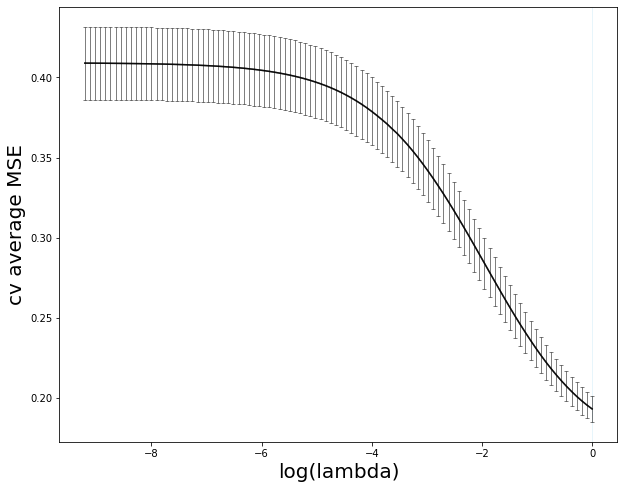

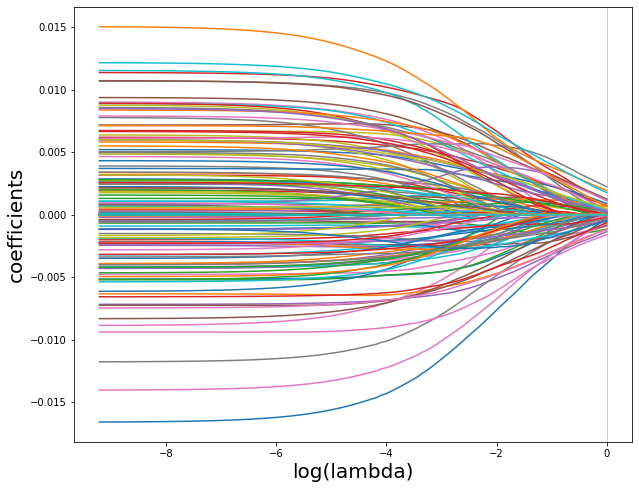

NameError: name 'masked_data' is not defined

In [12]:
print(time.strftime('%c', time.localtime(time.time())))
alpha = 0.005
coefs = elasticnet(X, y,
                   alpha=alpha,
                   n_jobs=16,
                   verbose=1,
                   max_lambda=1,
                   n_samples=5000)

task_name = f'piva2019_elasticnet_{n}_{alpha:.4f}'
result = get_map(coefs, masked_data, task_name=task_name, map_type='z', save_path='.', smoothing_sigma=1)
print(time.strftime('%c', time.localtime(time.time())))